# COVID-19 Article Clustering with Unknown Number of Clusters



### Goal
Automatically detect the number of clusters and article distribution over them, given over 50K articles. Cluster description (a list of top words best characterizing articles in a cluster) together with cluster's word cloud can then be used to answer specific challenge questions by assuming that answers could be found in articles of a few clusters rather than in all articles. In other words, the search for answers is supposed to become faster as queries would run against the fraction of all articles.

**Approach**:
<ol>
    <li>Unsupervised Learning task, because we don't have labels for the articles</li>
    <li>Text Clustering when the number of resulting clusters is unknown in advance</li>
    <li>Extensive text pre-processing, resulting in lists of words belonging to certain parts-of-speech in English only (non-English language articles are filtered out</li>
    <li>Use 2- and 3-grams with a TF-IDF vectorizer</li>
    <li>Use Affinity Propagation for clustering of a small number of articles (in order to determine both the number of clusters and cluster "seeds" and main topics), followed by iterative addition of the rest of articles, one-by-one, to the nearest cluster</li>
    <li>Extract top N words associated with each cluster and create a word cloud for each cluster</li>
</ol>

**Challenge**:

If one tries to cluster many thousands of COVID-19 articles at once, there will likely be a failure as all these articles belong to the same topic and their vector representations look similar, thus preventing a clustering algorithm, such as Affinity Propagation, to converge, or even if the clustering algorithm succeeded, there could one or two very big clusters and a few much smaller ones. Hence, to overcome this challenge, I suggest to initially cluster a small subset of randomly selected articles in order for minor subtopics to emerge in various small clusters. I call this stage the cluster seeding. Once it is done, the rest of the articles can be iteratively added to the found seeds, one-by-one.

### Dataset Description

#### Cite: [COVID-19 Open Research Dataset Challenge (CORD-19) | Kaggle](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge) <br>

**Text pre-processing and clustering sections of the project (cite):** *Text Analytics with Python: A Practical Real-World Approach to Gaining Actionable Insights from Your Data*, by Dipanjan Sarkar (Apress). Copyright 2016, ISBN-13 (pbk): 978-1-4842-2387-1. <br>

## Sources of Code
Data loading is borrowed from the notebook of Ivan Ega Pratama, from Kaggle.

#### Cite: [Dataset Parsing Code | Kaggle, COVID EDA: Initial Exploration Tool](https://www.kaggle.com/ivanegapratama/covid-eda-initial-exploration-tool)

General notebook flow is modeled on the notebook of Maksim Ekin.

#### Cite: [Kaggle, COVID-19 Literature Clustering](https://www.kaggle.com/maksimeren/covid-19-literature-clustering) 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import glob
import json
import pickle
import random

In [2]:
root_path = 'C:\Workbench\kaggle\CORD-19-research-challenge'

## Fetch All JSON Files under a Specified Folder

In [3]:
all_json = glob.glob(f'{root_path}/**/*.json', recursive=True)
len(all_json)

29315

## Helper: File Reader Class

In [4]:
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            # Abstract
            if 'abstract' in content.keys():  # some articles have abstract
                for entry in content['abstract']:
                    self.abstract.append(entry['text'])
            else:  # some articles don't have abstract
                 self.abstract.append('')       
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'
first_row = FileReader(all_json[0])
print(first_row)

0015023cc06b5362d332b3baf348d11567ca2fbb: word count: 194 22 Text word count: 5168 23 24 25 author/funder. All rights reserved. No reuse allowed without permission. Abstract 27 The positive stranded RNA genomes of picornaviruses comprise a si... VP3, and VP0 (which is further processed to VP2 and VP4 during virus assembly) (6). The P2 64 and P3 regions encode the non-structural proteins 2B and 2C and 3A, 3B (1-3) (VPg), 3C pro and 4 structura...


## Load Data into a Data Frame

In [5]:
%%time

import fasttext
# Load the fasttext language identification model (https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.ftz)
model = fasttext.load_model(root_path + '\\' + 'lid.176.ftz')

dict_ = {'paper_id': [], 'abstract': [], 'body_text': []}
for idx, entry in enumerate(all_json):
    if idx % (len(all_json) // 10) == 0:
        print(f'Processing index: {idx} of {len(all_json)}')
    content = FileReader(entry)
    # Filter out articles with empty body or written in language other than English
    if len(content.body_text) > 0 and model.predict(content.body_text.split('\n')[0], k=1)[0][0] == '__label__en':
        dict_['paper_id'].append(content.paper_id)
        dict_['abstract'].append(content.abstract)
        dict_['body_text'].append(content.body_text)
df = pd.DataFrame(dict_, columns=['paper_id', 'abstract', 'body_text'])
df.head()

Processing index: 0 of 29315
Processing index: 2931 of 29315
Processing index: 5862 of 29315
Processing index: 8793 of 29315
Processing index: 11724 of 29315
Processing index: 14655 of 29315
Processing index: 17586 of 29315
Processing index: 20517 of 29315
Processing index: 23448 of 29315
Processing index: 26379 of 29315
Processing index: 29310 of 29315
Wall time: 6min 38s


,paper_id,abstract,body_text
0,0015023cc06b5362d332b3baf348d11567ca2fbb,word count: 194 22 Text word count: 5168 23 24...,"VP3, and VP0 (which is further processed to VP..."
1,004f0f8bb66cf446678dc13cf2701feec4f36d76,,The 2019-nCoV epidemic has spread across China...
2,00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,Infectious bronchitis (IB) causes significant ...,"Infectious bronchitis (IB), which is caused by..."
3,0139ea4ca580af99b602c6435368e7fdbefacb03,Nipah Virus (NiV) came into limelight recently...,Nipah is an infectious negative-sense single-s...
4,013d9d1cba8a54d5d3718c229b812d7cf91b6c89,Background: A novel coronavirus (2019-nCoV) em...,"In December 2019, a cluster of patients with p..."


## Remove Duplicates if Present

In [6]:
print(f'The number of articles before duplicate removal: {df.shape[0]}')
df.drop_duplicates(['abstract', 'body_text'], inplace=True)
print(f'The number of articles after duplicate removal: {df.shape[0]}')

The number of articles before duplicate removal: 28531
The number of articles after duplicate removal: 28342


## Merge abstract and body_text Columns

In [7]:
df['text'] = df['abstract'] + " " + df['body_text']
# Remove blanks from both sides of text
df['text'] = df['text'].str.strip()
# Drop unnecessary columns
df.drop(['abstract', 'body_text'], axis=1, inplace=True)
print(df.shape)
df.head()

(28342, 2)


,paper_id,text
0,0015023cc06b5362d332b3baf348d11567ca2fbb,word count: 194 22 Text word count: 5168 23 24...
1,004f0f8bb66cf446678dc13cf2701feec4f36d76,The 2019-nCoV epidemic has spread across China...
2,00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,Infectious bronchitis (IB) causes significant ...
3,0139ea4ca580af99b602c6435368e7fdbefacb03,Nipah Virus (NiV) came into limelight recently...
4,013d9d1cba8a54d5d3718c229b812d7cf91b6c89,Background: A novel coronavirus (2019-nCoV) em...


## Remove Articles without Content 

In [8]:
df = df[df['text'].str.strip().astype(bool)]
print(df.shape)
df.head()

(28342, 2)


,paper_id,text
0,0015023cc06b5362d332b3baf348d11567ca2fbb,word count: 194 22 Text word count: 5168 23 24...
1,004f0f8bb66cf446678dc13cf2701feec4f36d76,The 2019-nCoV epidemic has spread across China...
2,00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,Infectious bronchitis (IB) causes significant ...
3,0139ea4ca580af99b602c6435368e7fdbefacb03,Nipah Virus (NiV) came into limelight recently...
4,013d9d1cba8a54d5d3718c229b812d7cf91b6c89,Background: A novel coronavirus (2019-nCoV) em...


## Helper: Text Pre-Processing Functions

In [9]:
import re
import nltk
from nltk.collocations import BigramCollocationFinder
from nltk.collocations import BigramAssocMeasures
import string


# Stopwords
stopword_list = nltk.corpus.stopwords.words('english')

# Part-of-Speech (POS) to find in text
# We are interested oly in certain adjectives and nouns
pos_tag_list = ['JJ', 'NN', 'NNP']

# Top 2-grams to extract from text
top_ngrams = 100


def remove_noisy_tokens(text):
    '''
    Remove tokens that are considered noisy for further analysis
    '''
    
    # Replaces the ASCII '�' symbol with '8'
    text = text.replace(u'\ufffd', '8')   
    # Removes all numbers and words including them. e.g., 'Year2000'
    text = re.sub(r"\S*\d\S*", "", text)
    # Removes email addresses
    text = re.sub(r"\S*@\S*\s?", "", text)
    # Removes URLs starting with 'https' and 'http'
    text = re.sub(r"http\S+", "", text)
    # Removes URLs starting with 'www'
    text = re.sub(r"www\S+", "", text)
    return text.strip()
    
    
def tokenize_text(text):
    '''
    Tokenize text into words
    '''
    
    tokens = nltk.word_tokenize(text) 
    tokens = [token.strip() for token in tokens]
    return tokens

   
def remove_special_characters(text):
    '''
    Remove any punctuation marks
    '''
    
    tokens = tokenize_text(text)
    pattern = re.compile('[{}]'.format(re.escape(string.punctuation)))
    filtered_tokens = filter(None, [pattern.sub(' ', token) for token in tokens])
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text
    
    
def remove_stopwords(text):
    '''
    Remove stopwords
    '''
    
    tokens = tokenize_text(text)
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    filtered_text = ' '.join(filtered_tokens) 
    return filtered_text


def remove_special_pos(text):
    '''
    Filter out redundant POS
    '''
    
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [token for token,pos_tag in nltk.pos_tag(tokens) if pos_tag in pos_tag_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text


def normalize_corpus(corpus, tokenize=False):
    '''
    Main function combining all text pre-processing steps
    '''
    
    normalized_corpus = []
    for text in corpus:
        text = remove_noisy_tokens(text)
        text = text.lower()
        text = remove_special_characters(text)
        text = remove_stopwords(text)
        text = remove_special_pos(text)
        if tokenize:
            text = tokenize_text(text)
            normalized_corpus.append(text)
        else:
            normalized_corpus.append(text)
           
    return normalized_corpus


def parse_document(document):
    '''
    Tokenize a document into a list of sentences
    '''
    
    document = re.sub('\n', ' ', document)
    if isinstance(document, str):
        document = document
    else:
        raise ValueError('Document is not string or unicode!')
    document = document.strip()
    sentences = nltk.sent_tokenize(document)
    sentences = [sentence.strip() for sentence in sentences]
    return sentences


def get_top_bigrams(corpus, top_n=100):
    '''
    Most frequent bigram detection
    '''
    
    finder = BigramCollocationFinder.from_documents([item.split() for item in corpus])
    bigram_measures = BigramAssocMeasures()                                                
    return finder.nbest(bigram_measures.raw_freq, top_n)   


def preprocess_text(text):
    '''
    Apply pre-processing techniques to document text
    '''
    
    # Extract sentences
    sentences = parse_document(text)
    # Pre-process (normalize) sentences
    norm_sentences = normalize_corpus(sentences)
    # Extract top bi-grams from each normalized sentence
    bigrams = get_top_bigrams(norm_sentences, top_n=top_ngrams)
    all_tokens = ' '.join(' '.join(tokens) for tokens in bigrams)
    return all_tokens, norm_sentences

## Pre-Process Text of All Articles

From text of every article, top N 2-grams are extracted after multi-stage pre-processing, each consisting of certain pre-specified parts-of-speech, such as nouns and adjectives

In [10]:
%%time

# Pre-process text of each article and add extra columns
result = [((idx % (df.shape[0] // 10) == 0) and print(f'Processing index: {idx} of {df.shape[0]}')) or preprocess_text(text) 
          for idx, text in enumerate(df['text'])]
df['tokens'] = [item[0] for item in result]
df['norm_sents'] = [item[1] for item in result]
#df['norm_sents'] = df['norm_sents'].apply('. '.join)

# As we don't need the original text anymore, this column can be dropped
df.drop(['text'], axis=1, inplace=True)
# Reset index
df.set_index('paper_id', inplace=True)
df.head()

Processing index: 0 of 28342
Processing index: 2834 of 28342
Processing index: 5668 of 28342
Processing index: 8502 of 28342
Processing index: 11336 of 28342
Processing index: 14170 of 28342
Processing index: 17004 of 28342
Processing index: 19838 of 28342
Processing index: 22672 of 28342
Processing index: 25506 of 28342
Processing index: 28340 of 28342
Wall time: 3h 30min 23s


,tokens,norm_sents
paper_id,,
0015023cc06b5362d332b3baf348d11567ca2fbb,author funder biorxiv preprint copyright holde...,"[word count text word count author funder, , r..."
004f0f8bb66cf446678dc13cf2701feec4f36d76,public health hubei province china january hea...,"[epidemic spread china, mass quarantine measur..."
00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,reuse permission author funder copyright holde...,[infectious bronchitis ib significant economic...
0139ea4ca580af99b602c6435368e7fdbefacb03,nipah virus anti nipah hydrogen bond analysis ...,"[nipah virus niv due outbreak kerala india, ni..."
013d9d1cba8a54d5d3718c229b812d7cf91b6c89,high risk author funder available author cc nc...,[background novel coronavirus wuhan city china...


## Extract the "Seed" Subset of Articles out of All Arrticles

In [11]:
%%time

# Due to the large amount of computation, all articles are hard to process at once
# Hence, let us start from a small number randomly picked articles
# Another reason for this start is that all articles belong to the same topic (COVID-19) and when there are many
# articles, the notion of similarity is lost (each article is similar to others), which leads to the failure of 
# convergence of a clustering algorithm
# By taking a small number of articles, we hope that division into sub-topics is better preserved, and the rest of 
# articles can be then added to formed clusters one-by-one

# Set seed size
seed_size = 100

# Randomly choose a small subset of articles
random.seed(12345)
seed_idx = random.sample(list(df.index.values), seed_size)
df_seed = df.loc[seed_idx, :].copy()

# Remove selected articles from the main Data Frame 
df = df[~df.index.isin(seed_idx)]
df_seed.head()

Wall time: 40 ms


,tokens,norm_sents
paper_id,,
3ab5bac23479ddada58d37cb139d5033bc9bfeaa,k þ active transport plasma membrane passive d...,"[life membrane ability level aqueous membrane,..."
dec3bae21563da31f703012a5a4920e0e854ae4c,et al brsv antigen brsv speci®c brsv infection...,[speci®c antibody different respiratory syncyt...
5daceb492bad28a61fc43c4be83a164042d8c430,author funder copyright holder holder preprint...,[rotavirus rv round cytoplasmic viral assemble...
5237c45681cad45eb4e6c51317e32c0e9b638c08,et al vector borne land use tick borne vectori...,[anthropocene context land use biodiversity im...
63aed9fa99e7df7846c24993fbf4d7aebb4d957a,et al spinal cord growth factor mixed phenotyp...,[disease dr friedrich current address brookdal...


## Helper: Vectorize Text Using TF-IDF

In [12]:
%%time

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def build_feature_matrix(documents, feature_type='tfidf',
                         ngram_range=(1, 1), min_df=0.0, max_df=1.0, max_features=None):
    '''
    Feature extraction
    '''

    feature_type = feature_type.lower().strip()  
    
    if feature_type == 'binary':
        vectorizer = CountVectorizer(binary=True, min_df=min_df,
                                     max_df=max_df, ngram_range=ngram_range, max_features=max_features)
    elif feature_type == 'frequency':
        vectorizer = CountVectorizer(binary=False, min_df=min_df,
                                     max_df=max_df, ngram_range=ngram_range, max_features=max_features)
    elif feature_type == 'tfidf':
        vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df, 
                                     ngram_range=ngram_range, max_features=max_features)
    else:
        raise Exception("Wrong feature type entered. Possible values: 'binary', 'frequency', 'tfidf'")

    feature_matrix = vectorizer.fit_transform(documents).astype(float)
    
    return vectorizer, feature_matrix

Wall time: 0 ns


## Vectorize Text of "Seed" Articles

In [13]:
# Extract features from documents
vectorizer, feature_matrix = \
build_feature_matrix(df_seed['tokens'], feature_type='tfidf', min_df=0.0, max_df=1.0, ngram_range=(1, 1), max_features=None)
feature_matrix.shape

(100, 4136)

## Helper: Text Clustering Functions

In [14]:
from collections import Counter
from wordcloud import WordCloud
from sklearn.cluster import AffinityPropagation
import scipy as sp
              

# This and the next functions are adopted from
# https://nbviewer.jupyter.org/github/LucasTurtle/national-anthems-clustering/blob/master/Cluster_Anthems.ipynb
def centroids_dict(centroids, index):
    '''
    Transform a centroids Data Frame into a dictionary to be used on wordcloud
    '''
    
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict


def generate_wordclouds(centroids):
    '''
    Generate word cloud for each cluster, display and save it in a PNG file
    '''
    
    wordcloud = WordCloud(max_font_size=100, background_color = "white")
    for i in range(0, len(centroids)):
        centroid_dict = centroids_dict(centroids, i)
        # Avoid zero max frequency edge case when a centroid contains all rare words that were not present when TF-IDF
        # features were computed
        centroid_dict = {word: frequency+(1e-4)*random.random() for word, frequency in centroid_dict.items()}
        wordcloud.generate_from_frequencies(centroid_dict)
        plt.figure()
        plt.title("Cluster {}".format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()
        wordcloud.to_file(root_path + "\\" + "cluster_{}.png".format(i))


def get_cluster_data(clustering_obj, data, feature_names, num_clusters,
                     topn_features=10):
    '''
    Extract important information about each cluster:
        - key words characterizing a cluster centroid
        - documents assigned to a cluster
    '''

    cluster_details = {} 
    # Get sorted indices of cluster centroids
    ordered_centroids = clustering_obj.cluster_centers_.argsort()[:, ::-1]
    
    for cluster_num in range(num_clusters):
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster_num'] = cluster_num
        # Get key features (by TFIDF score) for each cluster
        key_features = [feature_names[index] 
                        for index 
                        in ordered_centroids[cluster_num, :topn_features]]
        cluster_details[cluster_num]['key_features'] = key_features
        
        # Get documents belonging to each cluster
        documents = data[data['Cluster'] == cluster_num]['Title'].values.tolist()
        cluster_details[cluster_num]['documents'] = documents
    
    return cluster_details
       
    
def print_cluster_data(cluster_data):
    '''
    Print characteristics of each cluster
    '''
    
    for cluster_num, cluster_details in cluster_data.items():
        print('Cluster {} details:'.format(cluster_num))
        print('-'*100)
        print('Key features: ', cluster_details['key_features'])
        print('#articles in a cluster: ', len(cluster_details['documents']))
        #print('Documents in this cluster:')
        #print(', '.join(cluster_details['documents']))
        print('='*100)


def affinity_propagation(feature_matrix):
    '''
    Affinity propagation clustering
    '''
    
    ap = AffinityPropagation()
    if sp.sparse.issparse(feature_matrix):
        feature_matrix = feature_matrix.todense()
    ap.fit(feature_matrix)
    clusters = ap.labels_          
    return ap, clusters


def cluster_analysis(clustering_object, feature_names, titles, clusters,
                     topn_features, feature_matrix):
    '''
    Main function of cluster analysis
    '''
    
    # Get cluster centroids
    centroids = pd.DataFrame(clustering_object.cluster_centers_)
    centroids.columns = feature_names
    
    # Generate wordclouds for clusters
    generate_wordclouds(centroids)
            
    data = pd.DataFrame({'Title': titles, 'Cluster': clusters})
    # Get the total number of documents per cluster
    c = Counter(clusters)   
    print(f'Article distribution over clusters as (cluster_no, #articles): {c.items()}')
    # Get the total number of clusters
    num_clusters = len(c)
    print(f'The number of clusters: {num_clusters}')
    
    cluster_data = get_cluster_data(clustering_obj=clustering_object,
                                    data=data,
                                    feature_names=feature_names,
                                    num_clusters=num_clusters,
                                    topn_features=topn_features)         

    print_cluster_data(cluster_data)
    
    return cluster_data

## Cluster the "Seed" Set of Articles with Automatic Discovering the Number of Clusters and Cluster Seeds

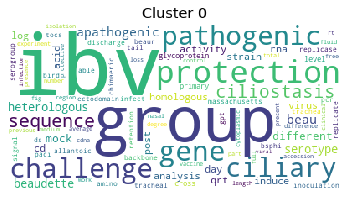

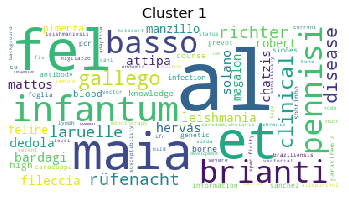

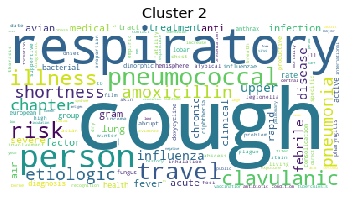

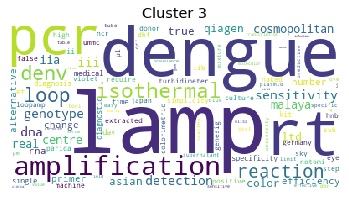

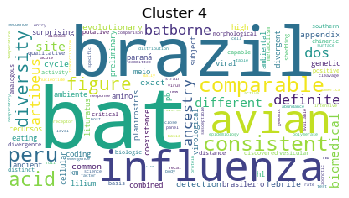

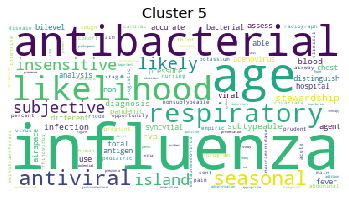

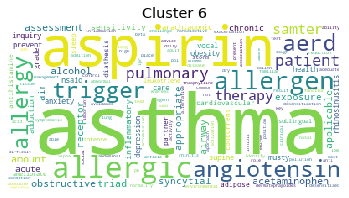

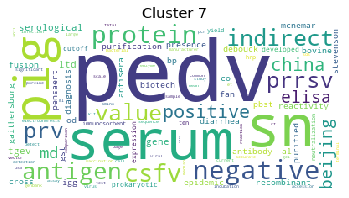

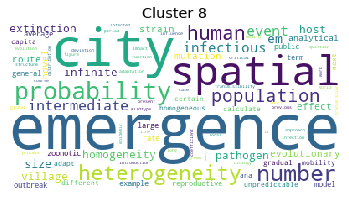

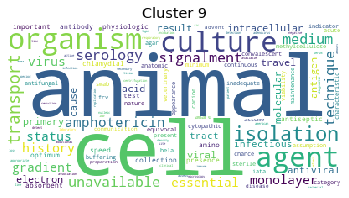

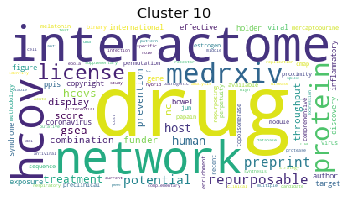

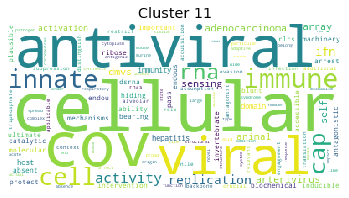

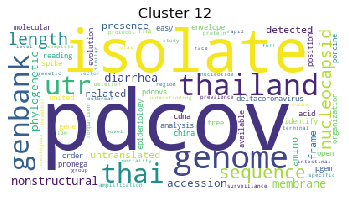

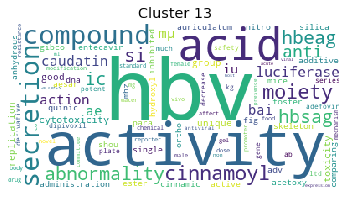

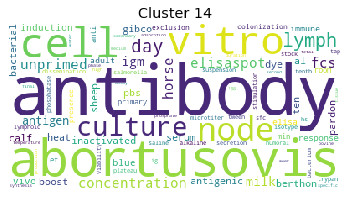

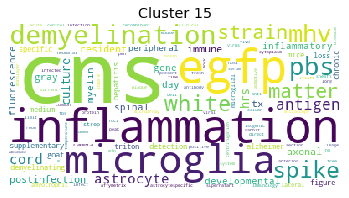

Article distribution over clusters as (cluster_no, #articles): dict_items([(9, 6), (14, 7), (11, 9), (1, 13), (15, 4), (2, 12), (0, 4), (5, 7), (8, 4), (13, 6), (3, 6), (12, 4), (4, 3), (6, 2), (7, 5), (10, 8)])
The number of clusters: 16
Cluster 0 details:
----------------------------------------------------------------------------------------------------
Key features:  ['ibv', 'group', 'protection', 'gene', 'pathogenic', 'challenge', 'ciliary', 'sequence', 'beau', 'ciliostasis', 'apathogenic', 'heterologous', 'beaudette', 'serotype', 'different', 'mock', 'rna', 'cd', 'induce', 'day', 'activity', 'strain', 'post', 'acid', 'analysis', 'qrt', 'virus', 'homologous', 'log', 'glycoprotein']
#articles in a cluster:  4
Cluster 1 details:
----------------------------------------------------------------------------------------------------
Key features:  ['al', 'fel', 'et', 'infantum', 'maia', 'brianti', 'basso', 'pennisi', 'gallego', 'clinical', 'disease', 'robert', 'manzillo', 'pimenta', 'ric

In [15]:
%%time

# Top features to describe each cluster
top_features = 30

# Get feature names
feature_names = vectorizer.get_feature_names()
        
# Get clusters using affinity propagation
cl_obj, clusters = affinity_propagation(feature_matrix=feature_matrix)

# Perform cluster analysis in depth
cluster_data = cluster_analysis(cl_obj, feature_names, df_seed.index.values, clusters, top_features, feature_matrix)

## Iteratively Assign Unlabeled Articles to the Found Clusters 

In [16]:
%%time

def update_cluster(idx, text):
    '''
    Add a new document to the nearest cluster and update all necessary information
    '''
    
    # Extract features from tokens
    feature_matrix = vectorizer.transform([text]).todense()
    # Find a cluster to assign the extracted feature vector to
    c = cl_obj.predict(feature_matrix)[0]
    # Get the number of documents in the nearest cluster
    n = sum(cl_obj.labels_ == c)
    # Get the current cluster centroid (before the update)
    centroid = cl_obj.cluster_centers_[c,:]
    # Convert numpy.matrix to numpy.ndarray
    feature_array = np.ravel(feature_matrix)
    # Update the cluster centroid
    updated_centroid = (feature_array + n*centroid) / (n + 1)
    cl_obj.cluster_centers_[c,:] = updated_centroid
    # Update cluster labels too
    cl_obj.labels_ = np.append(cl_obj.labels_, c)
    # Update cluster_data
    cluster_data[c]['documents'].append(idx)
    # Get indices of the centroid for cluster 'c'
    ordered_centroid = cl_obj.cluster_centers_.argsort()[c, ::-1]
    # Get key features (by TFIDF score) for each cluster
    key_features = [feature_names[i] for i in ordered_centroid[:top_features]]
    cluster_data[c]['key_features'] = key_features


# Update clusters as new articles are added
indices = df.index.values
[(i % 1000 == 0 and print(f'{i} articles are processed ...')) or update_cluster(idx, text) 
 for i, (idx, text) in enumerate(zip(indices, df['tokens']))]

# Show cluster_data after the update
print_cluster_data(cluster_data)

0 articles are processed ...
1000 articles are processed ...
2000 articles are processed ...
3000 articles are processed ...
4000 articles are processed ...
5000 articles are processed ...
6000 articles are processed ...
7000 articles are processed ...
8000 articles are processed ...
9000 articles are processed ...
10000 articles are processed ...
11000 articles are processed ...
12000 articles are processed ...
13000 articles are processed ...
14000 articles are processed ...
15000 articles are processed ...
16000 articles are processed ...
17000 articles are processed ...
18000 articles are processed ...
19000 articles are processed ...
20000 articles are processed ...
21000 articles are processed ...
22000 articles are processed ...
23000 articles are processed ...
24000 articles are processed ...
25000 articles are processed ...
26000 articles are processed ...
27000 articles are processed ...
28000 articles are processed ...
Cluster 0 details:
-------------------------------------

## Save the Vectorizer Model Object in a File

In [17]:
# Save the vectorizer in a file
with open(root_path + '\\' + 'vectorizer_model.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)

## Save the Clustering Model Object and Characteristics of All Clusters in Files 

In [18]:
# Save the clustering object in a file
with open(root_path + '\\' + 'clustering_model.pkl', 'wb') as file:
    pickle.dump(cl_obj, file)
# Save cluster data in a file
with open(root_path + '\\' + 'cluster_data.pkl', 'wb') as file:
    pickle.dump(cluster_data, file)

## Merge "Seed" and Main Data Frames and Save Result in a CSV File

In [19]:
# Write a data frame to a CSV file for later use
df = pd.concat([df_seed, df], sort=False)
df_seed.to_csv(root_path + '\\' + 'normalized_sentences_and_tokens.csv', header=True, index=True)